<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/tf-surrogate-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Trees as Surrogate Model for NNs

* Deep Neural Networks generalize well from training data
* However, they typically are black boxes and how they come to a conclusion is not comprehensible
* Some applications need explainability, though
  * the right to explanation is well established by the GDPR and United States' Credit score (https://en.wikipedia.org/wiki/Right_to_explanation, https://en.wikipedia.org/wiki/Credit_score_in_the_United_States)
  * neither Apple nor Goldman Sachs could explain why wife got worse score than husband in recent outbreak on twitter (https://twitter.com/dhh/status/1193391198922321921, https://twitter.com/chrisalbon/status/1193224719157190656, https://twitter.com/CNBC/status/1193992782630838278) 
* On top of that, NNs require more compute power and are hard to bring into production
* On the opposite side, hand-written rules when crafted well are much more comprehensible, integrate easily into existing software and are inexpensive to execute
* Unfortunately, they are hard to come up with and either
  * generalize well but underfit by quite a bit
  * or are hard highly detailed and again overfit and are hard to maintain
* Decision Trees are of similar nature as those hand written rules, but can be trained from data and can either be geared towards understandability or accuracy
* Unlike Neural Networks they tend to overfit when trained on real world data and are hard to regularize
* But what if we train decision trees on data generated by a neural network tuned for generalization?
* Our hope is that the high capacity of the deep neural network will be able to do a really good job learning the structures underlying the training data and then be able to be a good teacher to our decision tree
* As it turns out, this approach gives us a dial to be tuned between predictive power and explainability that goes all the way from hand crafted rules to deep neural networks
* As a bonus we also see that nearest neighbor approaches can benefit from this approach as well, since they no longer need to be trained on real data

https://en.wikipedia.org/wiki/Surrogate_model


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

dpi = 96
# dpi = 300

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 8)
# mpl.rcParams["figure.dpi"] = dpi
mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15)

font_size=15
title_font_size=25

# https://matplotlib.org/users/colormaps.html
from matplotlib.colors import ListedColormap

colors = ['#FF0000', '#0000FF', '#FFFF00']
cmap = ListedColormap(colors) 

In [2]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# will also work, but nightly build might contain surprises

# !pip install -q tf-nightly-gpu-2.0-preview

TensorFlow 2.x selected.


In [3]:
import tensorflow as tf
print(tf.__version__)

2.1.0-rc1


In [0]:
tf.random.set_seed(42)

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [0]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/
# https://matplotlib.org/gallery/images_contours_and_fields/contourf_demo.html

from matplotlib.ticker import FuncFormatter

import numpy as np

def meshGrid(x_data=None, y_data=None):
    h = 1  # step size in the mesh
    x_min, x_max = 10, 110
    y_min, y_max = 80, 170
#     x_min, x_max = x_data.min() - 1, x_data.max() + 1
#     y_min, y_max = y_data.min() - 1, y_data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)

def plot_samples(samples, ax, legend):
    classes = samples[2]
    scatter = ax.scatter(samples[0], samples[1], c=classes, cmap=cmap, s=50, marker='o', edgecolors='k')

    # https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/scatter_with_legend.html
    formatter = FuncFormatter(lambda s,t: "Many Accidents" if s == 0 else "No Accidents" if s == 1 else "Few Accidents")
    class_legend = ax.legend(*scatter.legend_elements(alpha=0.6, prop='colors', fmt=formatter), title="Classes")
    ax.add_artist(class_legend)
    
    return ax, scatter

def plot_samples_markers(samples, ax, legend):
  y = samples[2]
  bad = samples[y == 0]
  good = samples[y == 1]
  fair = samples[y == 2]

  labels = ["High Risk", "Low Risk", "Medium Risk"]
  classes = [bad, good, fair]
  markers = ['v', 'd', '^']

  for label, clazz, color, marker in zip(labels, classes, colors, markers):
      ax.scatter(
          clazz[0], 
          clazz[1],
          label=label,
          color=color,
          marker=marker,
          s=100,
          edgecolors='k',
          alpha=0.8)
  if legend:
    ax.legend()
  return ax, None
      

def plotPrediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                   n_samples=None, proba=True, prediction=True, legend=True, 
                   scatter=True,
                   ax=None
                  ):
    if x_data is not None:
      assert x_data.shape == y_data.shape, "x and y must have the same dimension"
    if x_data  is not None and ground_truth is not None:
      assert x_data.shape == ground_truth.shape, "input and ground truth need the same number of samples"
    xx,yy = meshGrid(x_data, y_data)
    if ax is None:
      fig, ax = plt.subplots()

    if clf:
        Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])

        if proba:
            probaZ = Z.max(axis=1)
            probaZ = probaZ.reshape(xx.shape)
            ax.contourf(xx, yy, probaZ, cmap=plt.cm.binary, alpha=.4)

        if prediction:
            Z = Z.argmax(axis=1)
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cmap, alpha=.3)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)
    
    if scatter:
      samples = pd.DataFrame(np.array([x_data, y_data, ground_truth]).T)
      if n_samples:
        samples = samples.sample(n_samples, random_state=42)
      plot_samples_markers(samples, ax, legend)
    return ax 


In [0]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/DJCordhose/ml-workshop/master/data/insurance-customers-1500.csv', sep=';')

In [0]:
y = df['group'].values
X = df.drop('group', axis='columns').values

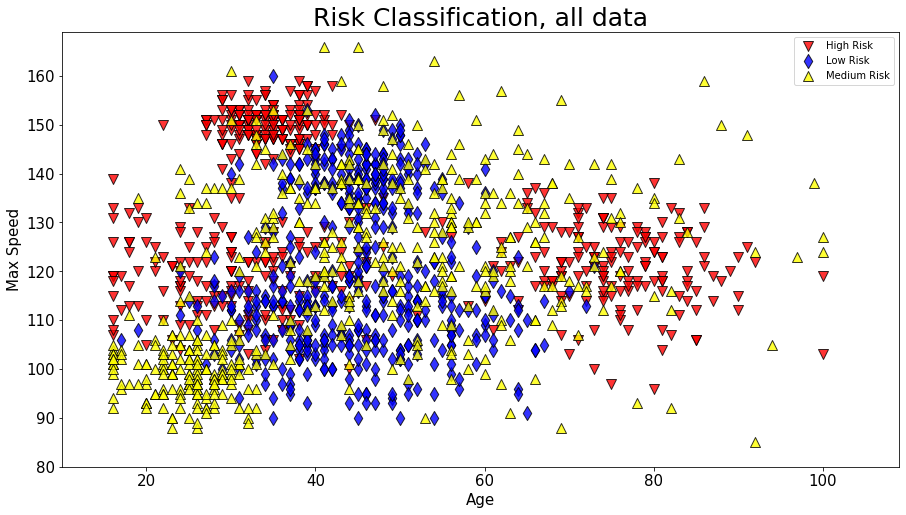

In [9]:
plotPrediction(clf=None, x_data=X[:, 1], y_data=X[:, 0], 
               x_label='Age', y_label='Max Speed', ground_truth=y,
                title="Risk Classification, all data");

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [0]:
# just the first two dimensions
X_train_2_dim = X_train[:, :2]
X_test_2_dim = X_test[:, :2]
X_2_dim = X[:, :2]

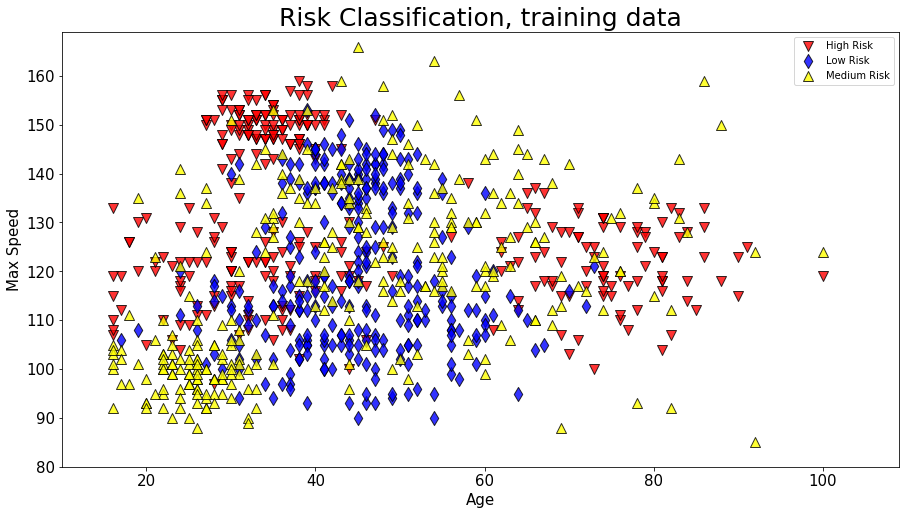

In [13]:
plotPrediction(clf=None, x_data=X_train[:, 1], y_data=X_train[:, 0], 
               x_label='Age', y_label='Max Speed', ground_truth=y_train,
                title="Risk Classification, training data");

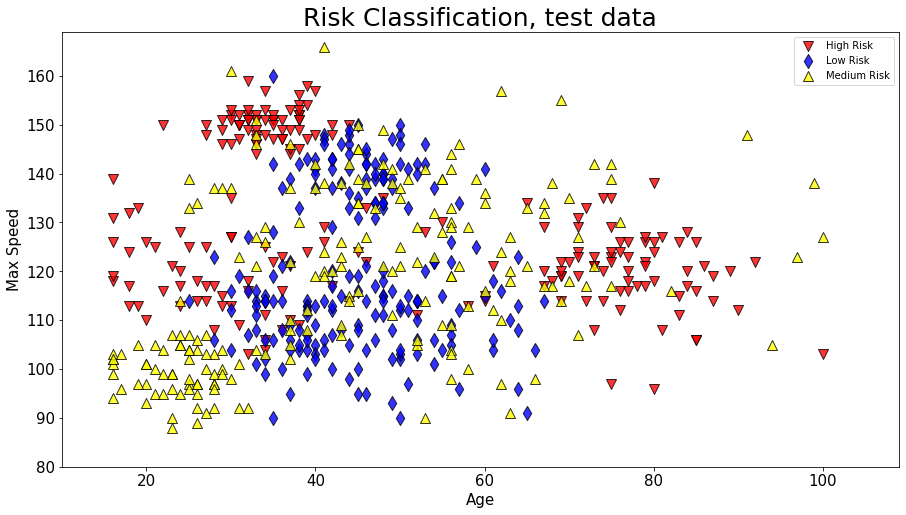

In [14]:
plotPrediction(clf=None, x_data=X_test[:, 1], y_data=X_test[:, 0], 
               x_label='Age', y_label='Max Speed', ground_truth=y_test,
               title="Risk Classification, test data");

## We have competing ways of regularization
1. Dropout and Batch Normalization (the default)
2. vanilla l1
   * should make our representation more sparse, edgier, maybe more suitable for decsision trees to emulate
3. l1 plus additonal custom orthogonal regularization as proposed by https://arxiv.org/abs/1904.05394
  * same effect, but might look more square?

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras import regularizers

num_features = 2
num_categories = 3

dropout = 0.6
dropout_model = tf.keras.Sequential()

dropout_model.add(Input(name='input', shape=(num_features,)))

dropout_model.add(Dense(name='hidden1', units=500))
dropout_model.add(Activation('selu'))
dropout_model.add(BatchNormalization())
dropout_model.add(Dropout(dropout))

dropout_model.add(Dense(name='hidden2', units=250))
dropout_model.add(Activation('selu'))
dropout_model.add(BatchNormalization())
dropout_model.add(Dropout(dropout))

dropout_model.add(Dense(name='output', units=num_categories, activation='softmax'))

dropout_model.compile(loss='sparse_categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy'])


In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras import regularizers

num_features = 2
num_categories = 3

l1_model = tf.keras.Sequential()

l1_model.add(Input(name='input', shape=(num_features,)))

l1_model.add(Dense(name='hidden1', 
                units=500,
                activation='selu',
                kernel_regularizer=regularizers.l1(1e-3)
                ))

l1_model.add(Dense(name='hidden2', 
               units=250,
                activation='selu',
               kernel_regularizer=regularizers.l1(1e-3)
              ))

l1_model.add(Dense(name='output', units=num_categories, activation='softmax'))

l1_model.compile(loss='sparse_categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy'])

In [0]:
import tensorflow as tf
from tensorflow.keras import regularizers

# custom regularization as described in
# III. L1-ORTHOGONAL REGULARIZATION
# https://arxiv.org/pdf/1904.05394.pdf

@tf.function
def gram_matrix(weight_matrix):
  return tf.matmul(tf.transpose(weight_matrix), weight_matrix)

@tf.function
def l1_ortho_reg(weight_matrix):
  gram = gram_matrix(weight_matrix)
  identity = tf.eye(gram.shape[0]) # be careful, tf.identity(gram) is just a copy 
  return tf.reduce_sum(tf.abs(gram - identity))

# Ω(W) = λ1 · Ω1(W) + λorth · Ωorth(W)
# λorth = [0.0001, 2.0])

λorth = 1e-2
# λorth = 5e-3
# λorth = 0
λ1 = 1e-3
@tf.function
def custom_reg(weight_matrix):
    l1_ortho = l1_ortho_reg(weight_matrix)
    l1 = regularizers.l1(λ1)(weight_matrix)
    return λorth * l1_ortho + l1
  
num_features = 2
num_categories = 3

l1_orth_model = tf.keras.Sequential()

l1_orth_model.add(Input(name='input', shape=(num_features,)))

l1_orth_model.add(Dense(name='hidden1', 
                units=500,
                activation='selu',
                kernel_regularizer=custom_reg
                ))

l1_orth_model.add(Dense(name='hidden2', 
               units=250,
                activation='selu',
                kernel_regularizer=custom_reg
              ))

l1_orth_model.add(Dense(name='output', units=num_categories, activation='softmax'))

l1_orth_model.compile(loss='sparse_categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy'])

In [18]:
# all models work well, but have largely different decision boundaries
# they do not simplify the decision tree by much (if at all)

# model = dropout_model
# model = l1_model
model = l1_orth_model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 500)               1500      
_________________________________________________________________
hidden2 (Dense)              (None, 250)               125250    
_________________________________________________________________
output (Dense)               (None, 3)                 753       
Total params: 127,503
Trainable params: 127,503
Non-trainable params: 0
_________________________________________________________________


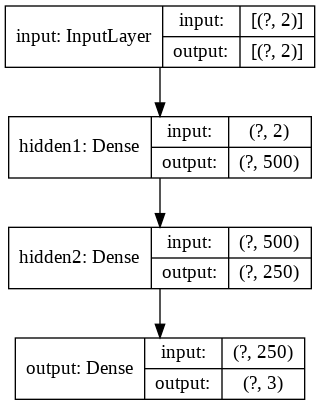

In [19]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, dpi=dpi)

In [20]:
%%time 

# BATCH_SIZE = 10
BATCH_SIZE = 500
# EPOCHS = 1000 # for bn / dropout
EPOCHS = 3000 # for l1/l2

history = model.fit(x = X_train_2_dim,
                    y = y_train,
                    validation_data=(X_test_2_dim, y_test),
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    verbose=0)

CPU times: user 49.4 s, sys: 4.27 s, total: 53.7 s
Wall time: 42.2 s


In [21]:
train_loss, train_accuracy = model.evaluate(X_train_2_dim, y_train, batch_size=BATCH_SIZE, verbose=0)
train_loss, train_accuracy

(7.950507058037652, 0.67444444)

In [22]:
test_loss, test_accuracy = model.evaluate(X_test_2_dim, y_test, batch_size=BATCH_SIZE, verbose=0)
test_loss, test_accuracy

(7.92525299390157, 0.69)

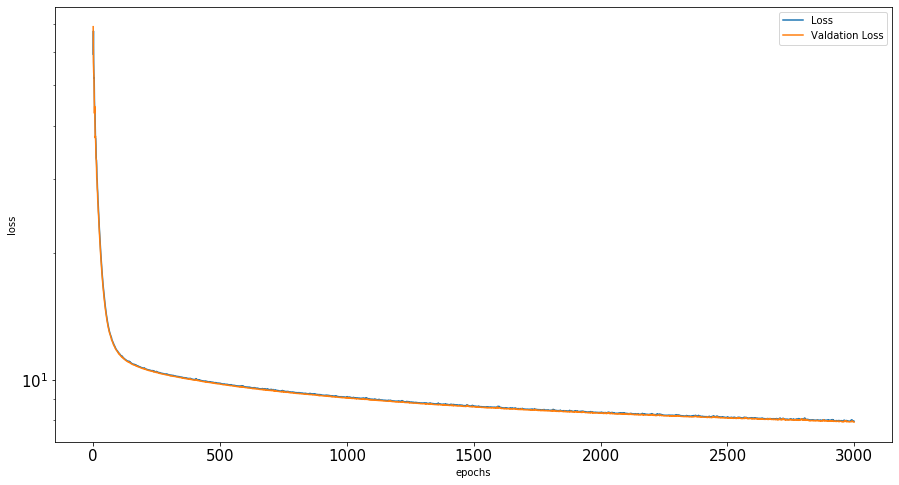

In [23]:
plt.yscale('log')

plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(["Loss", "Valdation Loss"]);

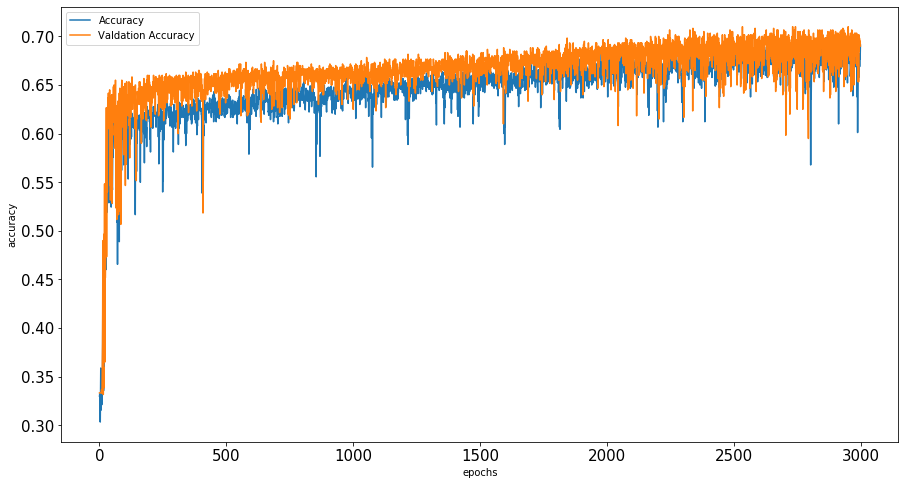

In [24]:
plt.ylabel("accuracy")
plt.xlabel("epochs")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.legend(["Accuracy", "Valdation Accuracy"]);

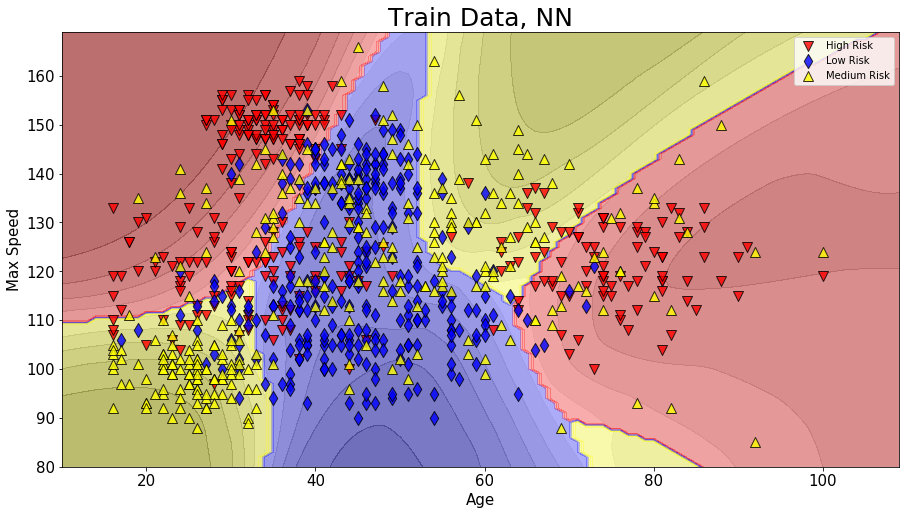

In [25]:
plotPrediction(model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, NN");

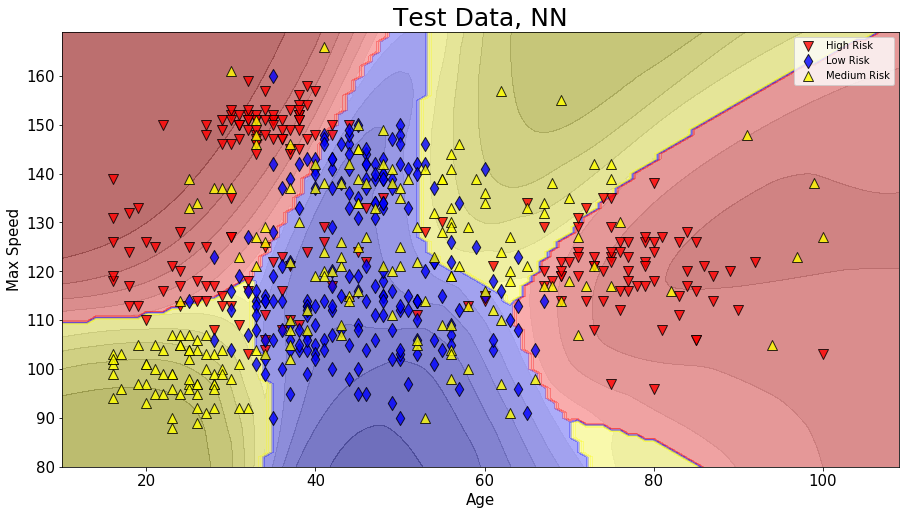

In [26]:
plotPrediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, NN");

## Outstanding solution, but we can not explain it any more

## On the other side of the spectrum we have manual models, not powerful, but comprehensible

In [0]:
red = high = 0
green = low =1
yellow = medium = 2

probas = np.array([
                   [1, 0, 0],
                   [0, 1, 0],
                   [0, 0, 1]
])

class ClassifierBase:
    def predict(self, X):
        return np.array([ self.predict_single(x) for x in X])
    def predict_proba(self, X):
        return np.array([probas[xi] for xi in self.predict(X)])
    def score(self, X, y):
        n = len(y)
        correct = 0
        predictions = self.predict(X)
        for prediction, ground_truth in zip(predictions, y):
            if prediction == ground_truth:
                correct = correct + 1
        return correct / n

In [0]:
from random import randrange

class RandomClassifier(ClassifierBase):
    def predict_single(self, x):
        return randrange(3)
random_clf = RandomClassifier()        

In [29]:
random_clf.score(X_2_dim, y)

0.34

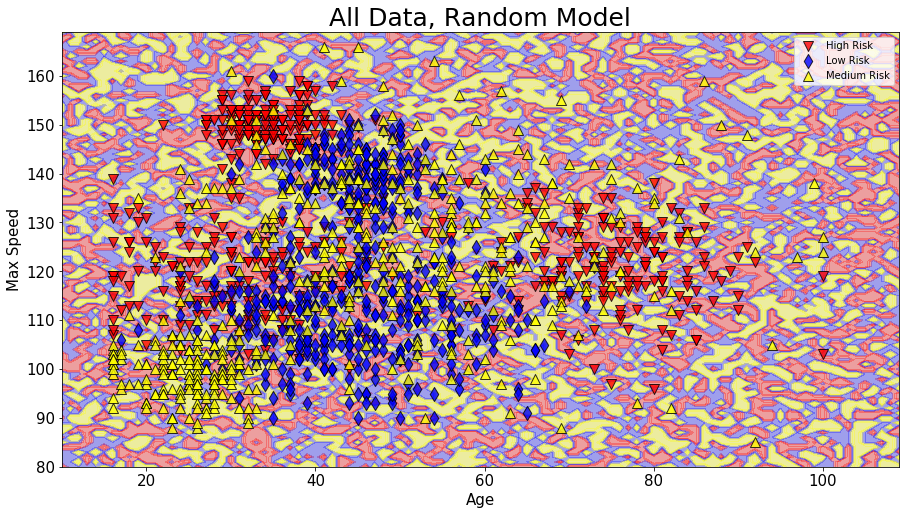

In [30]:
plotPrediction(random_clf, X_2_dim[:, 1], X_2_dim[:, 0], 
               'Age', 'Max Speed', y,
                title="All Data, Random Model");

In [0]:
class RuleClassifier(ClassifierBase):
    def predict_single(self, x):
        speed, age = x
        if age < 25:
            if speed > 110:
                return high
            else:
                return medium
        if age > 70:
            return high
        if speed > 145:
            return high
        # this default vastly simplifies rule set    
        return low
rule_clf = RuleClassifier()        

In [32]:
rule_clf.score(X_2_dim, y)

0.5673333333333334

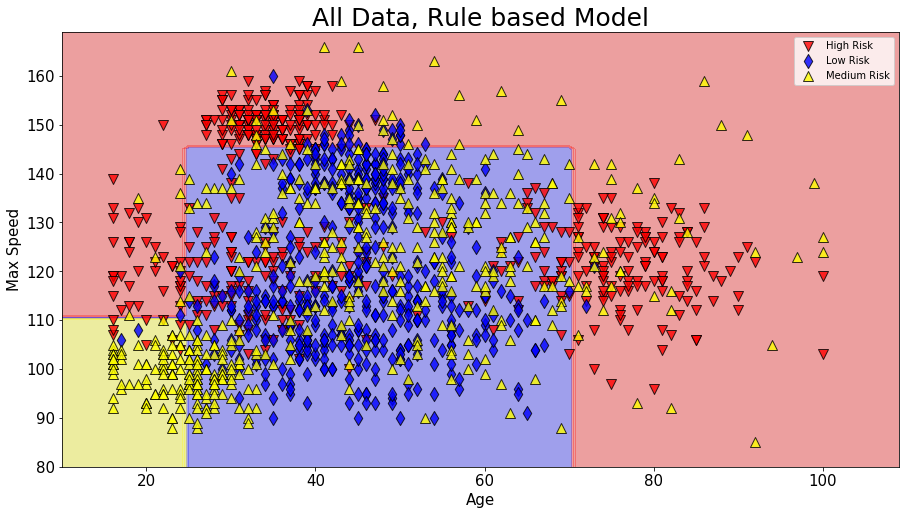

In [33]:
plotPrediction(rule_clf, X_2_dim[:, 1], X_2_dim[:, 0], 
               'Age', 'Max Speed', y,
                title="All Data, Rule based Model");

# Main Question: Can we have the best of both worlds?
## Or at least more randomly choose how to compromise?

### Direct Training of Decision Tree

In [34]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier()
%time dt_model.fit(X_train_2_dim, y_train)

CPU times: user 2.13 ms, sys: 4 µs, total: 2.13 ms
Wall time: 2.2 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [35]:
dt_model.score(X_train_2_dim, y_train)

0.96

In [36]:
dt_model.score(X_test_2_dim, y_test)

0.5983333333333334

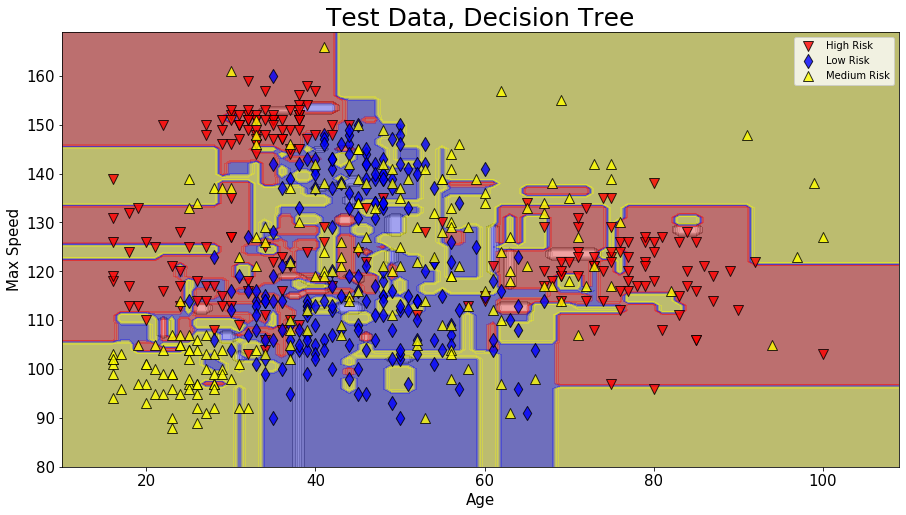

In [37]:
plotPrediction(dt_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Decision Tree");

In [38]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(max_depth=5)
%time dt_model.fit(X_train_2_dim, y_train)

CPU times: user 674 µs, sys: 1 ms, total: 1.68 ms
Wall time: 1.36 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [39]:
dt_model.score(X_train_2_dim, y_train)

0.7322222222222222

In [40]:
dt_model.score(X_test_2_dim, y_test)

0.675

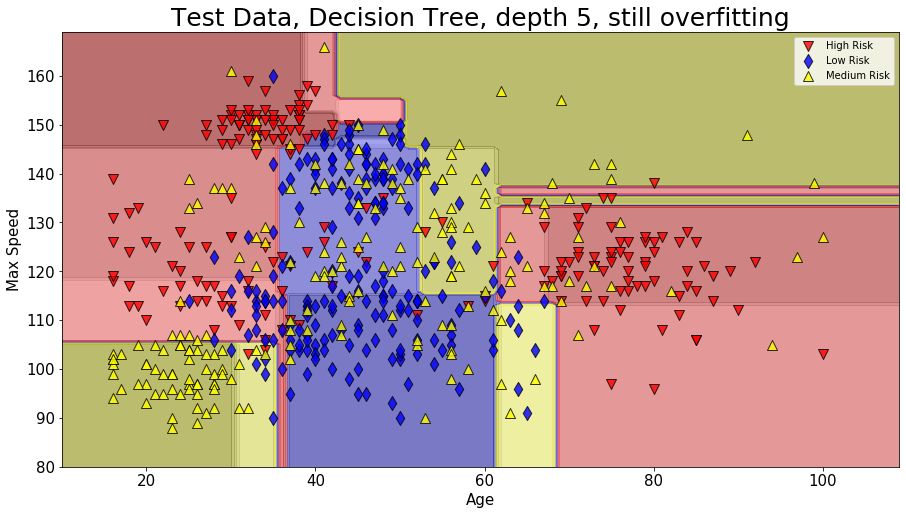

In [41]:
plotPrediction(dt_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Decision Tree, depth 5, still overfitting");

### Surrogate Data

In [42]:
xx,yy = meshGrid()
xx.shape, yy.shape

((90, 100), (90, 100))

In [43]:
mesh_data = np.c_[yy.ravel(), xx.ravel()]
mesh_data.shape

(9000, 2)

In [44]:
mesh_data[0]

array([80, 10])

In [45]:
pred = model.predict(mesh_data)
pred.shape

(9000, 3)

In [46]:
pred_sparse = pred.argmax(axis=1)
pred_sparse.shape

(9000,)

In [47]:
np.unique(pred_sparse, return_counts=True)

(array([0, 1, 2]), array([4659, 1946, 2395]))

### Surrogate Tree

In [48]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier()
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 6.73 ms, sys: 2.24 ms, total: 8.98 ms
Wall time: 19.6 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

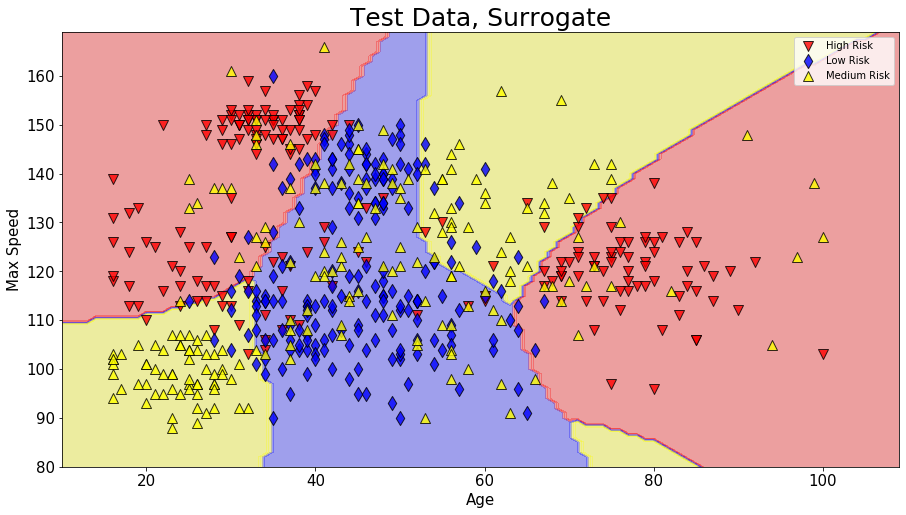

In [49]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Surrogate");

In [50]:
surrogate_model.tree_.max_depth

12

In [51]:
surrogate_model.score(mesh_data, pred_sparse)

1.0

In [52]:
surrogate_model.score(X_train_2_dim, y_train)

0.6744444444444444

In [53]:
surrogate_model.score(X_test_2_dim, y_test)

0.69

## Reduce Depth: 7

In [54]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(max_depth=7)
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 7.19 ms, sys: 1.74 ms, total: 8.93 ms
Wall time: 10 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [55]:
surrogate_model.tree_.max_depth

7

In [56]:
surrogate_model.score(mesh_data, pred_sparse)

0.9804444444444445

In [57]:
surrogate_model.score(X_train_2_dim, y_train)

0.6844444444444444

In [58]:
surrogate_model.score(X_test_2_dim, y_test)

0.69

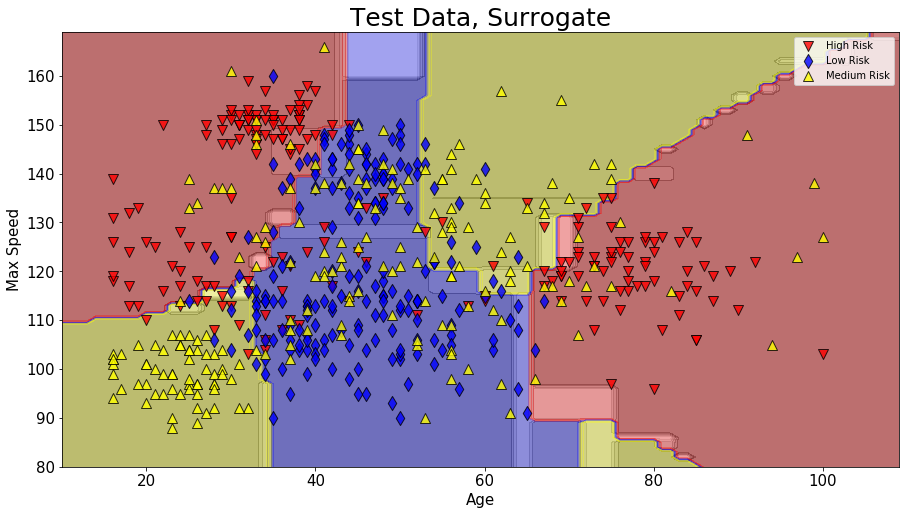

In [59]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Surrogate");

In [0]:
# from sklearn.tree import plot_tree

# feature_names=['Speed', 'Age']
# class_names=['high', 'medium', 'low']

# plt.figure(figsize=(350, 50), dpi=96)
# plot_tree(surrogate_model, 
#           feature_names=feature_names,
#           class_names=class_names,
#           impurity=False,
#           label='none',
#           filled=True,
#           fontsize=25,
#           proportion=True);

## Reduce Depth: 5

In [61]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(max_depth=5)
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 7.42 ms, sys: 0 ns, total: 7.42 ms
Wall time: 10.2 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [62]:
surrogate_model.tree_.max_depth

5

In [63]:
surrogate_model.score(mesh_data, pred_sparse)

0.9436666666666667

In [64]:
surrogate_model.score(X_train_2_dim, y_train)

0.6677777777777778

In [65]:
surrogate_model.score(X_test_2_dim, y_test)

0.6583333333333333

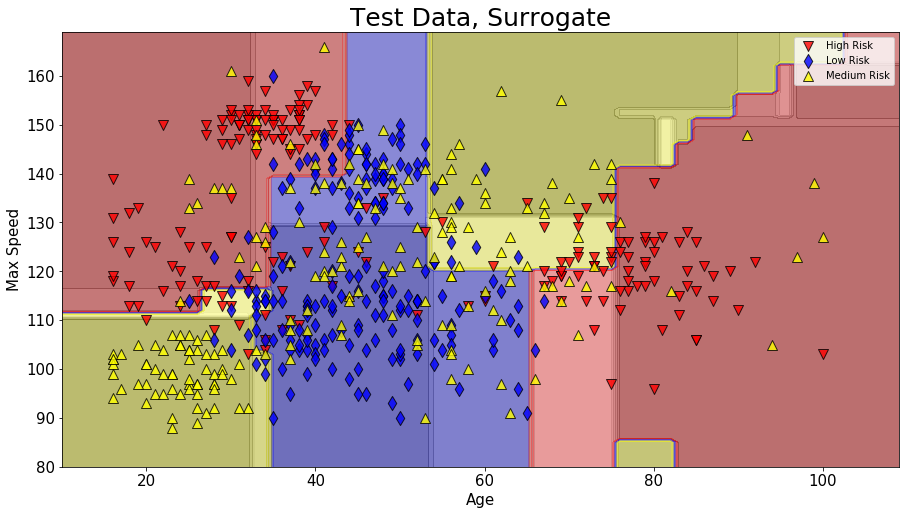

In [66]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Surrogate");

## Reduce Depth: 4

In [67]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(max_depth=4)
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 6.44 ms, sys: 23 µs, total: 6.47 ms
Wall time: 5.97 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [68]:
surrogate_model.tree_.max_depth

4

In [69]:
surrogate_model.score(mesh_data, pred_sparse)

0.8831111111111111

In [70]:
surrogate_model.score(X_train_2_dim, y_train)

0.62

In [71]:
surrogate_model.score(X_test_2_dim, y_test)

0.6183333333333333

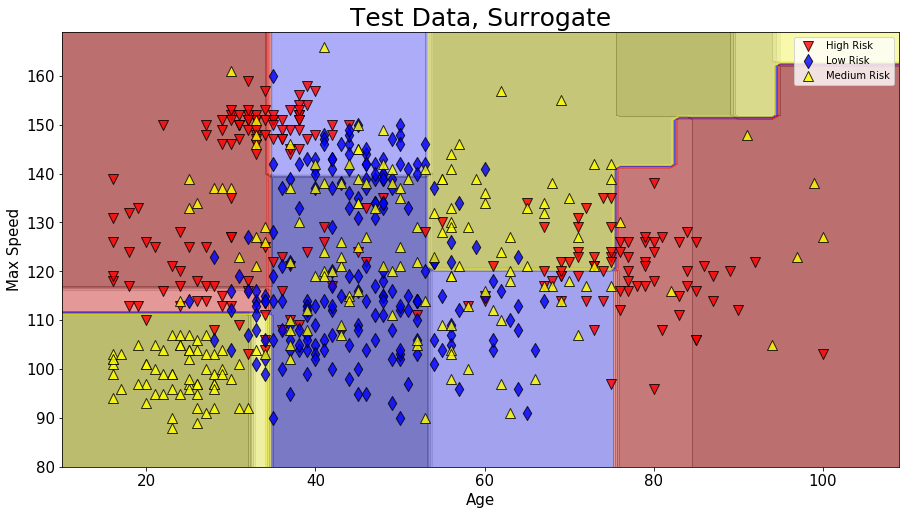

In [72]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Surrogate");

## Reduce Depth: 3

In [73]:
from sklearn.tree import DecisionTreeClassifier

# surrogate_model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=250)
surrogate_model = DecisionTreeClassifier(max_depth=3)

%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 5.07 ms, sys: 0 ns, total: 5.07 ms
Wall time: 5.07 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [74]:
surrogate_model.tree_.max_depth

3

In [75]:
surrogate_model.score(mesh_data, pred_sparse)

0.8253333333333334

In [76]:
surrogate_model.score(X_train_2_dim, y_train)

0.6077777777777778

In [77]:
surrogate_model.score(X_test_2_dim, y_test)

0.6233333333333333

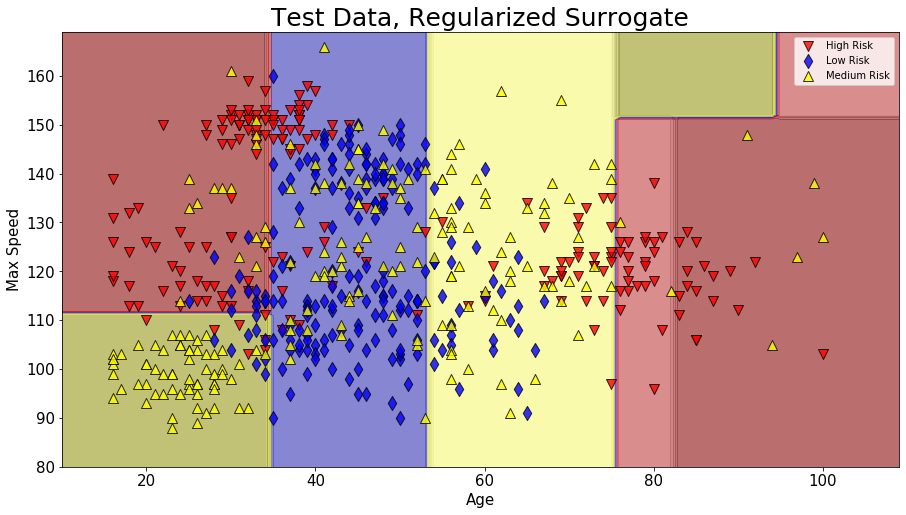

In [78]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Regularized Surrogate");

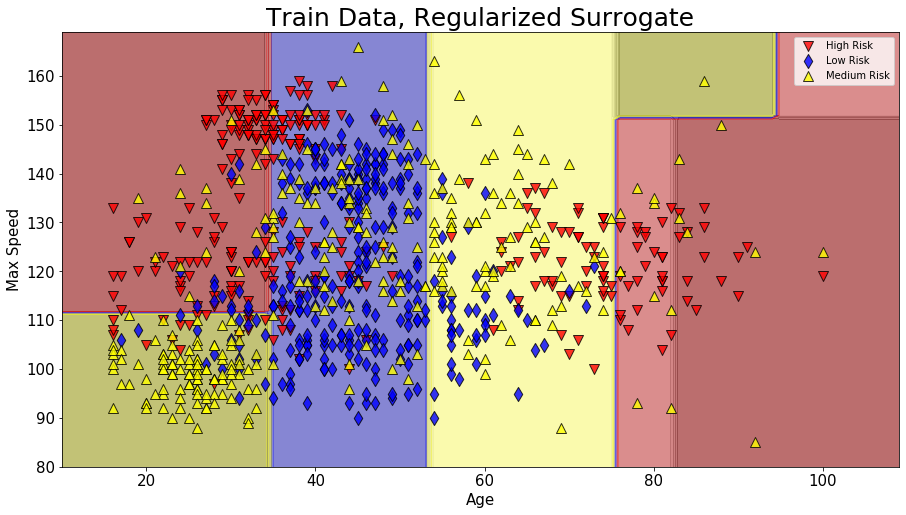

In [79]:
plotPrediction(surrogate_model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, Regularized Surrogate");

## Reduce Depth: 2

In [80]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(max_depth=2)

%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 3.38 ms, sys: 0 ns, total: 3.38 ms
Wall time: 3.4 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [81]:
surrogate_model.tree_.max_depth

2

In [82]:
surrogate_model.score(mesh_data, pred_sparse)

0.6671111111111111

In [83]:
surrogate_model.score(X_train_2_dim, y_train)

0.4766666666666667

In [84]:
surrogate_model.score(X_test_2_dim, y_test)

0.48833333333333334

In [85]:
surrogate_model.score(X_2_dim, y)

0.48133333333333334

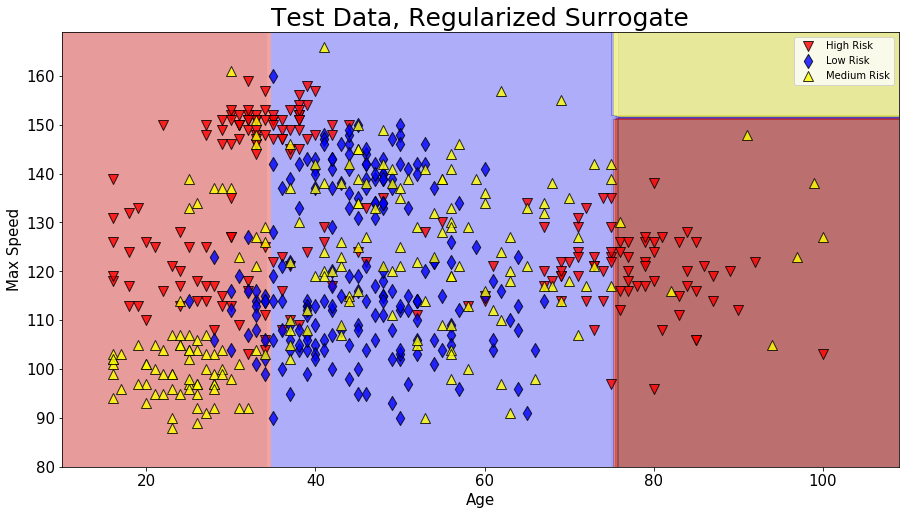

In [86]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Regularized Surrogate");

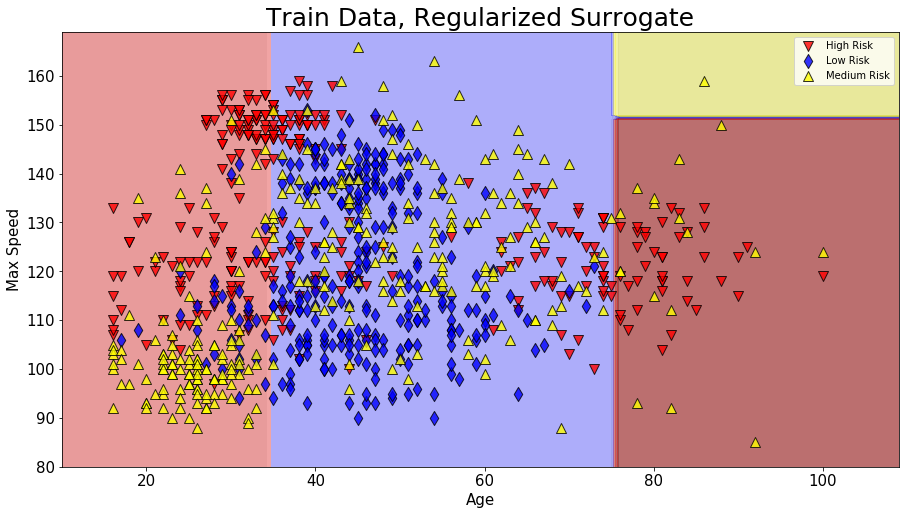

In [87]:
plotPrediction(surrogate_model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, Regularized Surrogate");

## Reduce Depth: 1

In [88]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(max_depth=1)

%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 2.22 ms, sys: 17 µs, total: 2.24 ms
Wall time: 2.25 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [89]:
surrogate_model.tree_.max_depth

1

In [90]:
surrogate_model.score(mesh_data, pred_sparse)

0.5176666666666667

In [91]:
surrogate_model.score(X_train_2_dim, y_train)

0.33444444444444443

In [92]:
surrogate_model.score(X_test_2_dim, y_test)

0.3333333333333333

In [93]:
surrogate_model.score(X_2_dim, y)

0.334

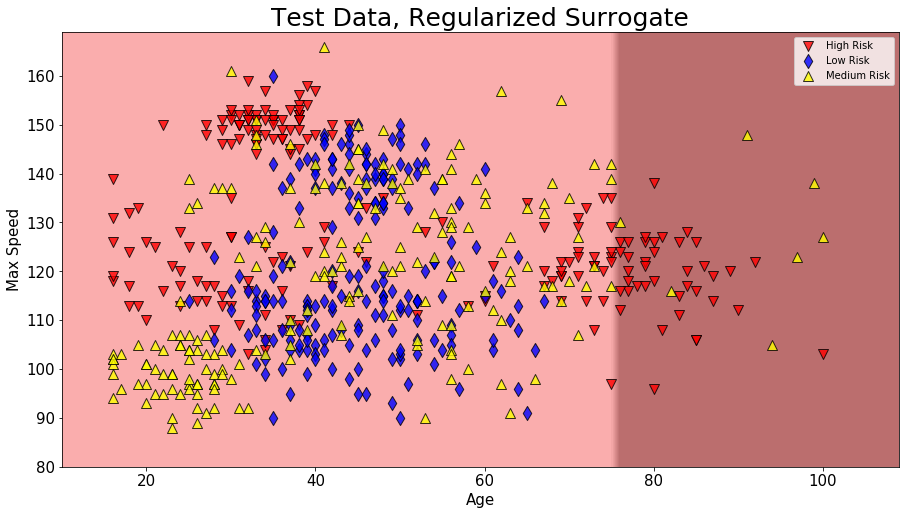

In [94]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Regularized Surrogate");

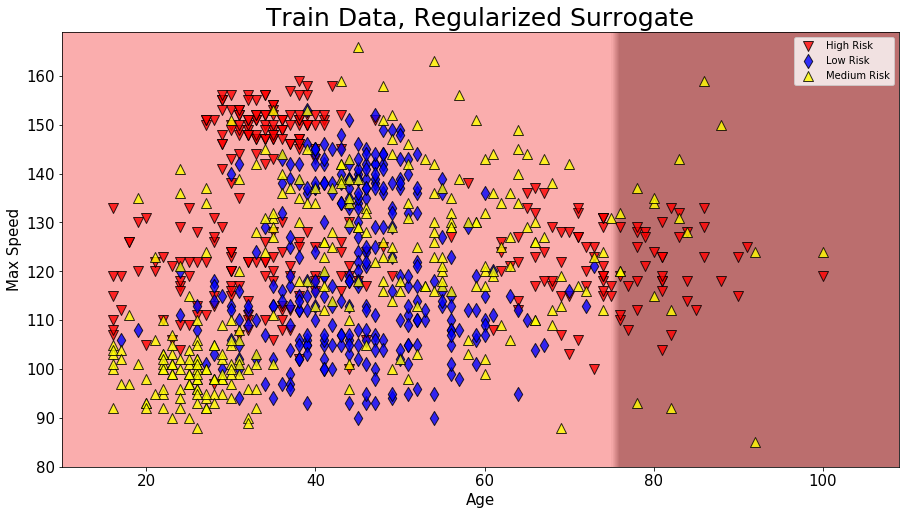

In [95]:
plotPrediction(surrogate_model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, Regularized Surrogate");

## Analyze for simple, but reasonable tree

In [96]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(
    max_depth=4,
    presort=True,
    # max_leaf_nodes = 4
    max_leaf_nodes = 6
                                         )
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 3.17 ms, sys: 8 µs, total: 3.18 ms
Wall time: 6 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=6,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=True,
                       random_state=None, splitter='best')

In [97]:
surrogate_model.tree_.max_depth

4

In [98]:
surrogate_model.score(mesh_data, pred_sparse)

0.8441111111111111

In [99]:
surrogate_model.score(X_train_2_dim, y_train)

0.6188888888888889

In [100]:
surrogate_model.score(X_test_2_dim, y_test)

0.6183333333333333

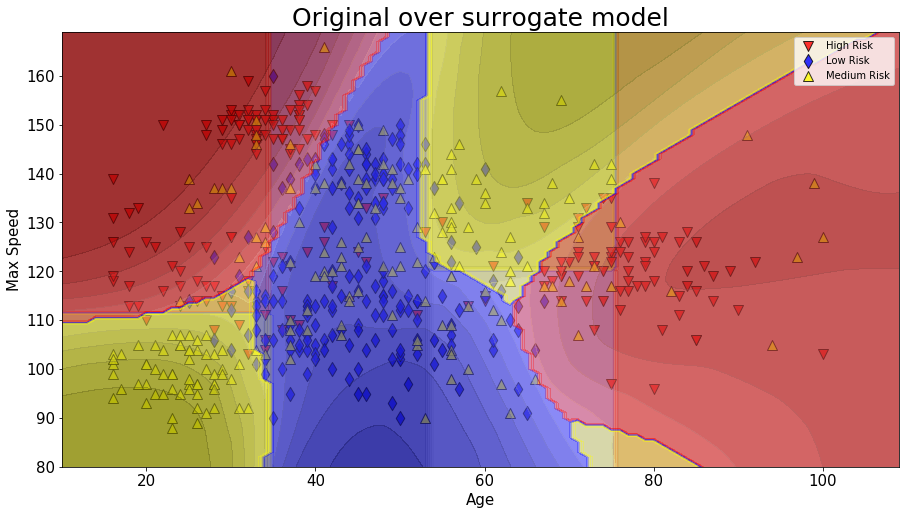

In [101]:
ax = plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test)
plotPrediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test, ax=ax, scatter=False,
                title="Original over surrogate model");

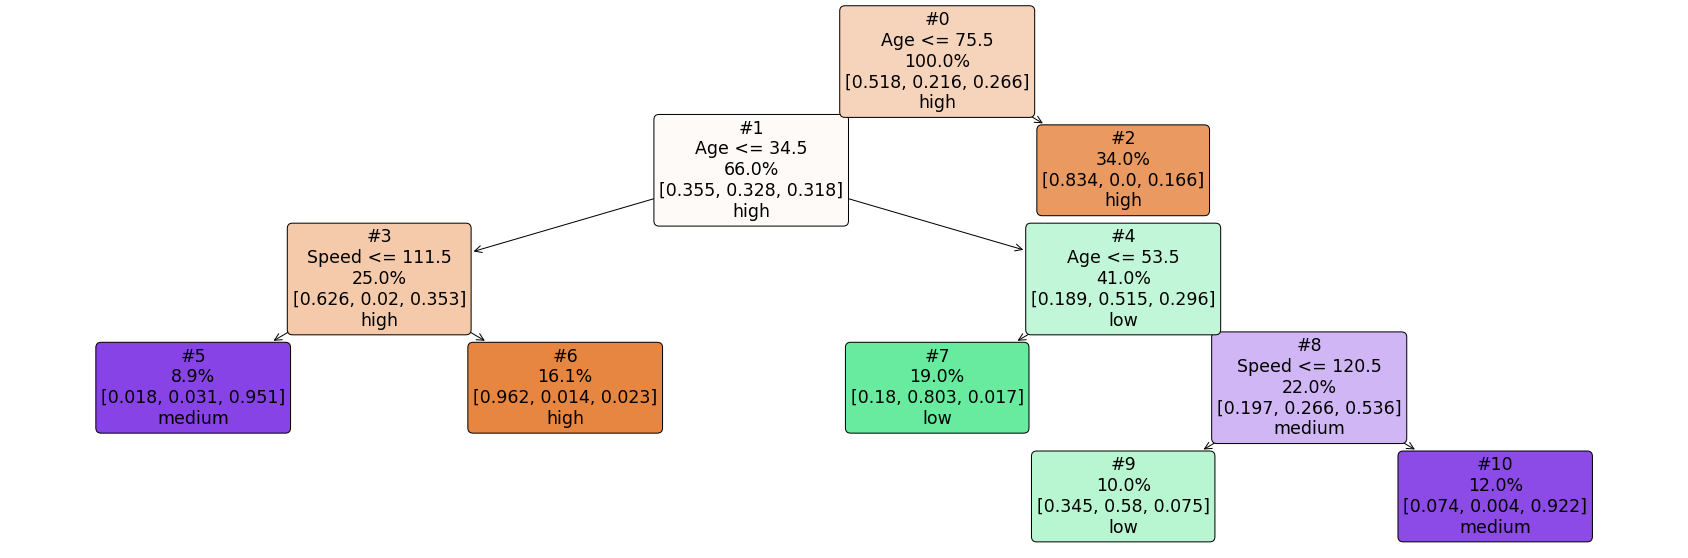

In [102]:
# https://scikit-learn.org/stable/modules/tree.html
# https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html
# https://stackoverflow.com/questions/42891148/changing-colors-for-decision-tree-plot-created-using-export-graphviz
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

feature_names=['Speed', 'Age']
class_names=['high', 'low', 'medium']

plt.figure(figsize=(30, 10))
plot_tree(surrogate_model, 
          feature_names=feature_names,
          class_names=class_names,
          impurity=False,
          label='none',
          rounded=True,
          node_ids=True,
          proportion=True,
          filled=True);

In [0]:
sample = [100, 35]
# sample = [100, 60]
# sample = [120, 17]

In [104]:
surrogate_model.predict([sample])

array([1])

In [105]:
leaf_id = surrogate_model.apply([sample])
leaf_id

array([7])

In [106]:
node_indicator = surrogate_model.decision_path([sample])
node_index = node_indicator.indices[node_indicator.indptr[0]:
                                    node_indicator.indptr[1]]
node_index

array([0, 1, 4, 7], dtype=int32)

## Analyzing tree structure

In [107]:
# https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

from sklearn.tree import _tree

def explain_decision(model, sample, feature_names, class_names):

  feature = model.tree_.feature
  threshold = model.tree_.threshold
  value = model.tree_.value

  node_indicator = model.decision_path([sample])
  node_index = node_indicator.indices[node_indicator.indptr[0]:
                                      node_indicator.indptr[1]]

  for node_id in node_index:
      if feature[node_id] == _tree.TREE_UNDEFINED:
          print(class_names[value[node_id].argmax(axis=1)[0]])
          continue

      if (sample[feature[node_id]] <= threshold[node_id]):
          threshold_sign = "<="
      else:
          threshold_sign = ">"

      print("%s(= %s) %s %s"
            % (feature_names[feature[node_id]],
              sample[feature[node_id]],
              threshold_sign,
              threshold[node_id]))
      
explain_decision(surrogate_model, sample, feature_names, class_names)      

Age(= 35) <= 75.5
Age(= 35) > 34.5
Age(= 35) <= 53.5
low


In [108]:
# https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree

def generate_code(model, feature_names, class_names):
    tree_ = model.tree_
    feature = model.tree_.feature
    threshold = model.tree_.threshold
    value = model.tree_.value

    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print ("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print ("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print ("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print ("{}return '{}'".format(indent, class_names[value[node].argmax(axis=1)[0]]))

    recurse(0, 1)
generate_code(surrogate_model, feature_names, class_names)    

def tree(Speed, Age):
  if Age <= 75.5:
    if Age <= 34.5:
      if Speed <= 111.5:
        return 'medium'
      else:  # if Speed > 111.5
        return 'high'
    else:  # if Age > 34.5
      if Age <= 53.5:
        return 'low'
      else:  # if Age > 53.5
        if Speed <= 120.5:
          return 'low'
        else:  # if Speed > 120.5
          return 'medium'
  else:  # if Age > 75.5
    return 'high'


### Visualizing Prediction Path using dtreeviz

https://github.com/parrt/dtreeviz

In [0]:
import sys

if 'google.colab' in sys.modules:
  !pip install -q dtreeviz

In [110]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(
    max_depth=3,
    presort=True,
    max_leaf_nodes = 6
                                         )
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 3.52 ms, sys: 47 µs, total: 3.56 ms
Wall time: 3.52 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=6,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=True,
                       random_state=None, splitter='best')

In [111]:
surrogate_model.score(mesh_data, pred_sparse)

0.8095555555555556

In [112]:
surrogate_model.score(X_train_2_dim, y_train)

0.6077777777777778

In [113]:
surrogate_model.score(X_test_2_dim, y_test)

0.6233333333333333

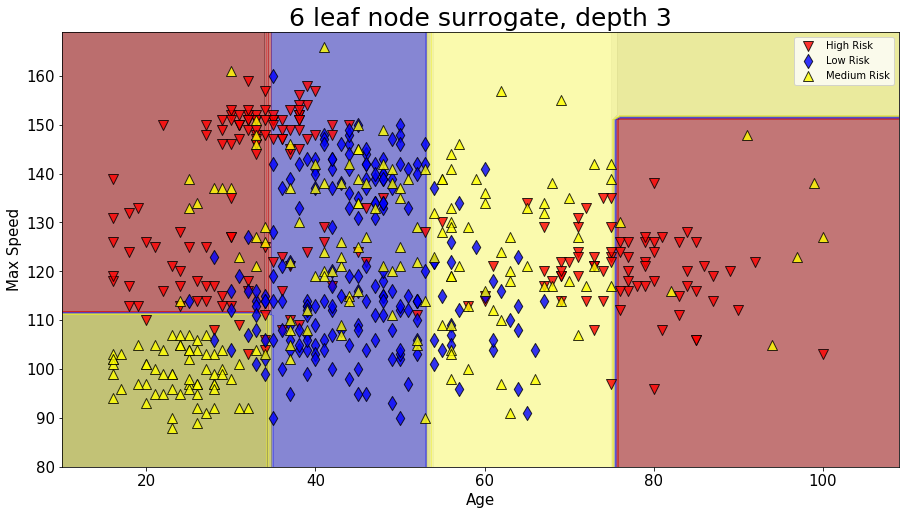

In [114]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="6 leaf node surrogate, depth 3");

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


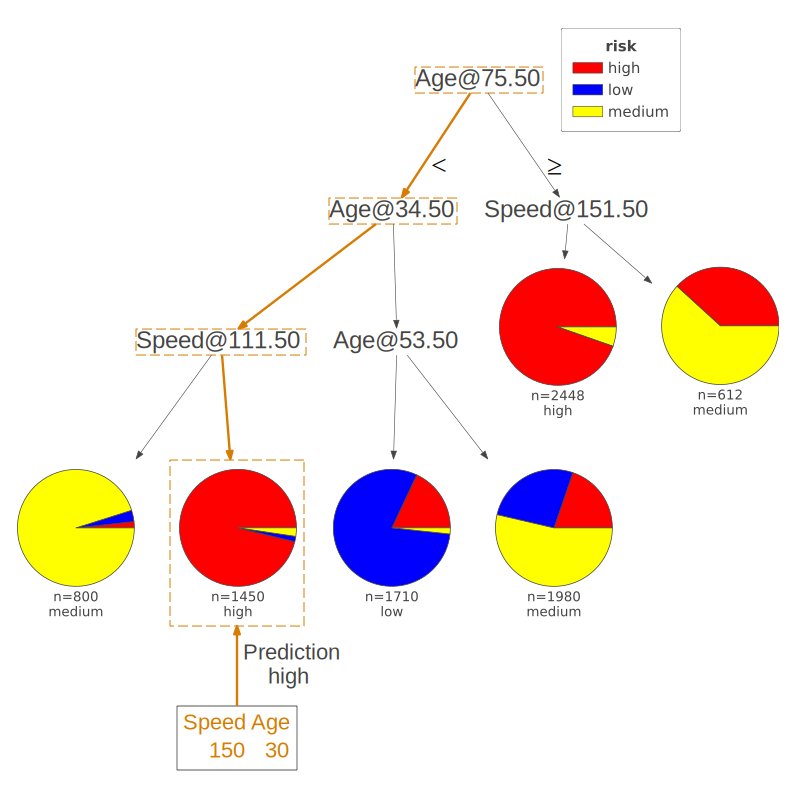

In [115]:
from dtreeviz.trees import dtreeviz

# sample = [100, 35]
sample = [150, 30]
# sample = [100, 60]
# sample = [120, 17]

viz = dtreeviz(surrogate_model,
               mesh_data, pred_sparse,
               target_name='risk',
               feature_names=feature_names,
               class_names=class_names,
               X=sample,
               colors={'classes': [
                   None,  # 0 classes
                   None,  # 1 class
                   None,  # 2 classes
                   ['#FF0000', '#0000FF', '#FFFF00'] # 3 classes
                   ]},
               fancy=False,
               scale=2
#                scale=3
)
viz

## Even KNN is an option now, since we are no longer working on real data

In [116]:
from sklearn.neighbors import KNeighborsClassifier
surrogate_model = KNeighborsClassifier(n_neighbors=5)
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 5.78 ms, sys: 188 µs, total: 5.97 ms
Wall time: 14.2 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [117]:
surrogate_model.score(mesh_data, pred_sparse)

0.9995555555555555

In [118]:
surrogate_model.score(X_train_2_dim, y_train)

0.6744444444444444

In [119]:
surrogate_model.score(X_test_2_dim, y_test)

0.6916666666666667

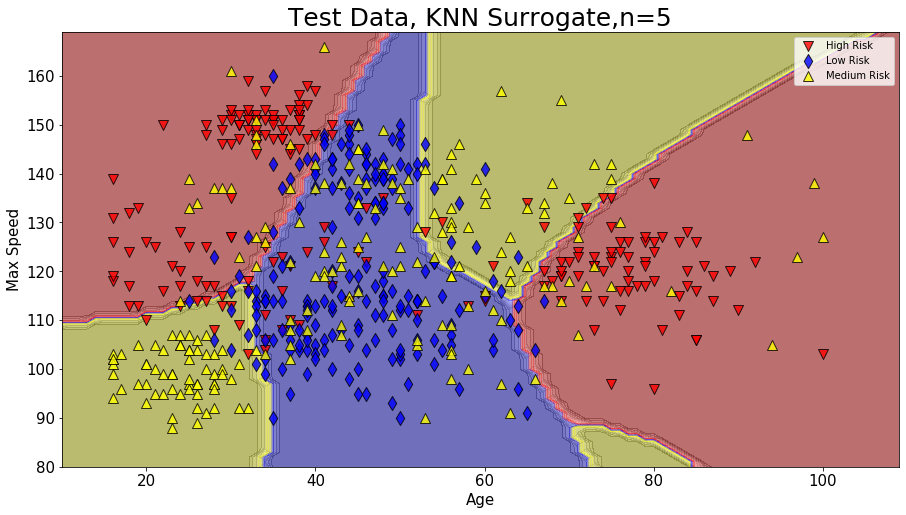

In [120]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, KNN Surrogate,n=5");

In [121]:
from sklearn.neighbors import KNeighborsClassifier
surrogate_model = KNeighborsClassifier(n_neighbors=1)
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 5.23 ms, sys: 0 ns, total: 5.23 ms
Wall time: 5.4 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [122]:
surrogate_model.score(mesh_data, pred_sparse)

1.0

In [123]:
surrogate_model.score(X_train_2_dim, y_train)

0.6744444444444444

In [124]:
surrogate_model.score(X_test_2_dim, y_test)

0.69

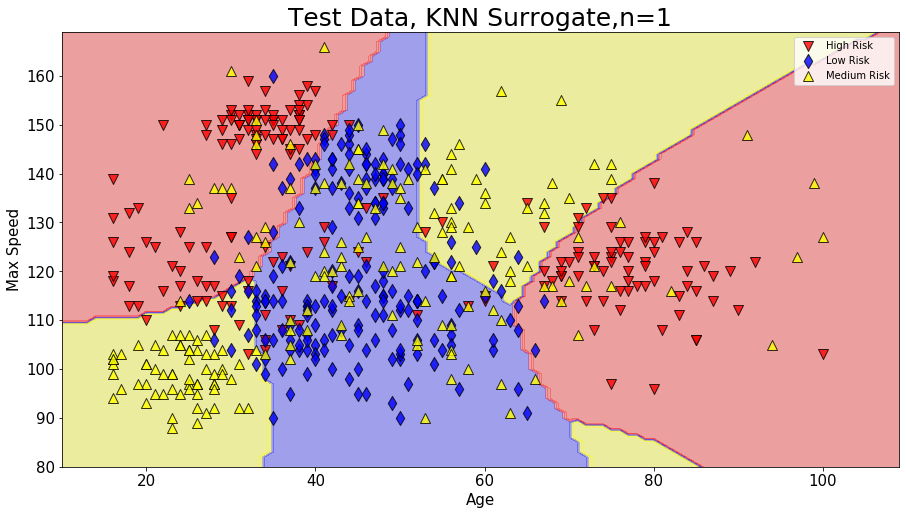

In [125]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, KNN Surrogate,n=1");